In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import umap
import tqdm

/home/tig687/.conda/envs/isoformer-real/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DATA_PATH = '/home/tig687/regularizedSB/sc_data/umap_subset_10k.h5ad'

def load_and_prepare_data():
    """Load data and add normalized layer"""
    adata = sc.read_h5ad(DATA_PATH)
    
    # Normalize and log-transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Select highly variable genes
    sc.pp.highly_variable_genes(adata, n_top_genes=200)
    adata_hvg = adata[:, adata.var.highly_variable].copy()
    
    return adata_hvg

def compute_umap_embedding(adata, n_neighbors=30, min_dist=0.3):
    """Compute UMAP embedding"""
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X')
    sc.tl.umap(adata, min_dist=min_dist)
    return adata

def plot_main_umap(adata):
    """Main UMAP colored by drug and treatment status"""
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Plot 1: Color by drug
    sc.pl.umap(adata, color='product_name', ax=axes[0], show=False, 
               title='UMAP by Drug', frameon=False)
    
    # Plot 2: Color by treatment status (control vs treated)
    adata.obs['is_treated'] = (adata.obs['product_name'] != 'Vehicle').astype(str)
    sc.pl.umap(adata, color='is_treated', ax=axes[1], show=False,
               title='Control vs Treated', frameon=False, palette=['#1f77b4', '#ff7f0e'])
    
    # Plot 3: Color by cell line
    sc.pl.umap(adata, color='cell_type', ax=axes[2], show=False,
               title='UMAP by Cell Line', frameon=False)
    
    plt.tight_layout()
    plt.show()

def plot_drug_facets(adata):
    """Faceted UMAP showing each drug separately"""
    drugs = [d for d in adata.obs['product_name'].unique() if d != 'Vehicle']
    
    n_drugs = len(drugs)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, drug in enumerate(drugs):
        ax = axes[idx]
        
        # Subset to this drug + vehicle
        mask = (adata.obs['product_name'] == drug) | (adata.obs['product_name'] == 'Vehicle')
        adata_sub = adata[mask].copy()
        
        # Create treatment label
        adata_sub.obs['status'] = adata_sub.obs['product_name'].apply(
            lambda x: 'Control' if x == 'Vehicle' else 'Treated'
        )
        
        # Plot
        sc.pl.umap(adata_sub, color='status', ax=ax, show=False,
                   title=f'{drug}', frameon=False, 
                   palette={'Control': '#cccccc', 'Treated': '#d62728'},
                   legend_loc='none')
    
    # Remove extra subplots
    for idx in range(len(drugs), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

def plot_displacement_vectors(adata):
    """Show average displacement from control to treated for each drug"""
    drugs = [d for d in adata.obs['product_name'].unique() if d != 'Vehicle']
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    #plot points in grey
    umap_coords = adata.obsm['X_umap']
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c='lightgray', s=10, alpha=0.3, rasterized=True)
    
    # For each drug, compute centroid displacement
    colors = plt.cm.Set2(np.linspace(0, 1, len(drugs)))
    
    for idx, drug in enumerate(drugs):
        # Control centroid
        control_mask = adata.obs['product_name'] == 'Vehicle'
        control_centroid = umap_coords[control_mask].mean(axis=0)
        
        # Treated centroid
        treated_mask = adata.obs['product_name'] == drug
        treated_centroid = umap_coords[treated_mask].mean(axis=0)
        
        # Draw arrow
        dx = treated_centroid[0] - control_centroid[0]
        dy = treated_centroid[1] - control_centroid[1]
        
        ax.arrow(control_centroid[0], control_centroid[1], 
                dx, dy, 
                head_width=0.3, head_length=0.3, 
                fc=colors[idx], ec=colors[idx], 
                linewidth=2, alpha=0.8, label=drug)
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('Average Perturbation Vectors (Control → Treated)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect('equal', 'box')
    
    plt.tight_layout()
    plt.show()

In [ ]:
adata = load_and_prepare_data()
adata = compute_umap_embedding(adata, n_neighbors=30, min_dist=0.5)


Loading data...
Computing UMAP embedding...


/home/tig687/.conda/envs/isoformer-real/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Generating visualizations...


'plot_drug_facets(adata)\nplot_displacement_vectors(adata)\nplot_cell_line_response(adata)\n\nprint("\nAll visualizations saved to:", OUTPUT_DIR)\nprint("\nSummary:")\nprint(f"  Total cells: {adata.n_obs}")\nprint(f"  Genes (HVG): {adata.n_vars}")\nprint(f"  Drugs: {len([d for d in adata.obs[\'product_name\'].unique() if d != \'Vehicle\'])}")\nprint(f"  Cell lines: {len(adata.obs[\'cell_type\'].unique())}")\'\n'

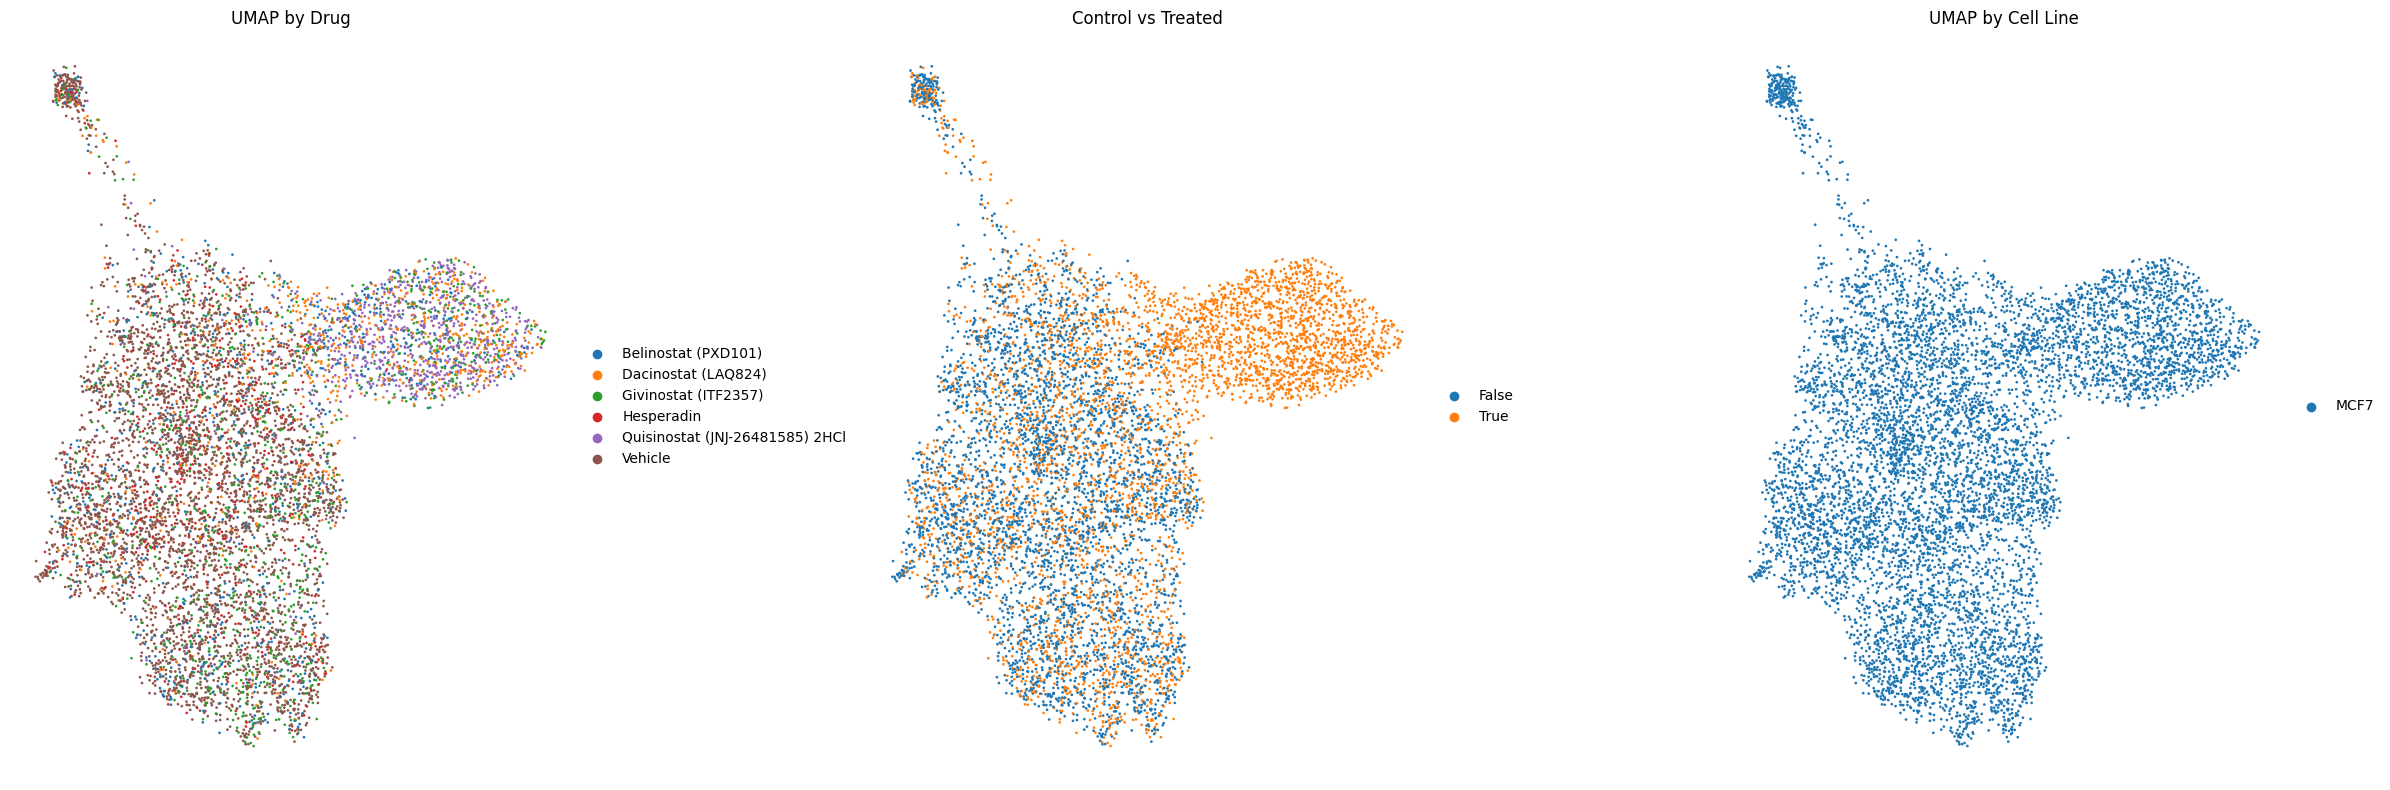

In [15]:
plot_main_umap(adata)

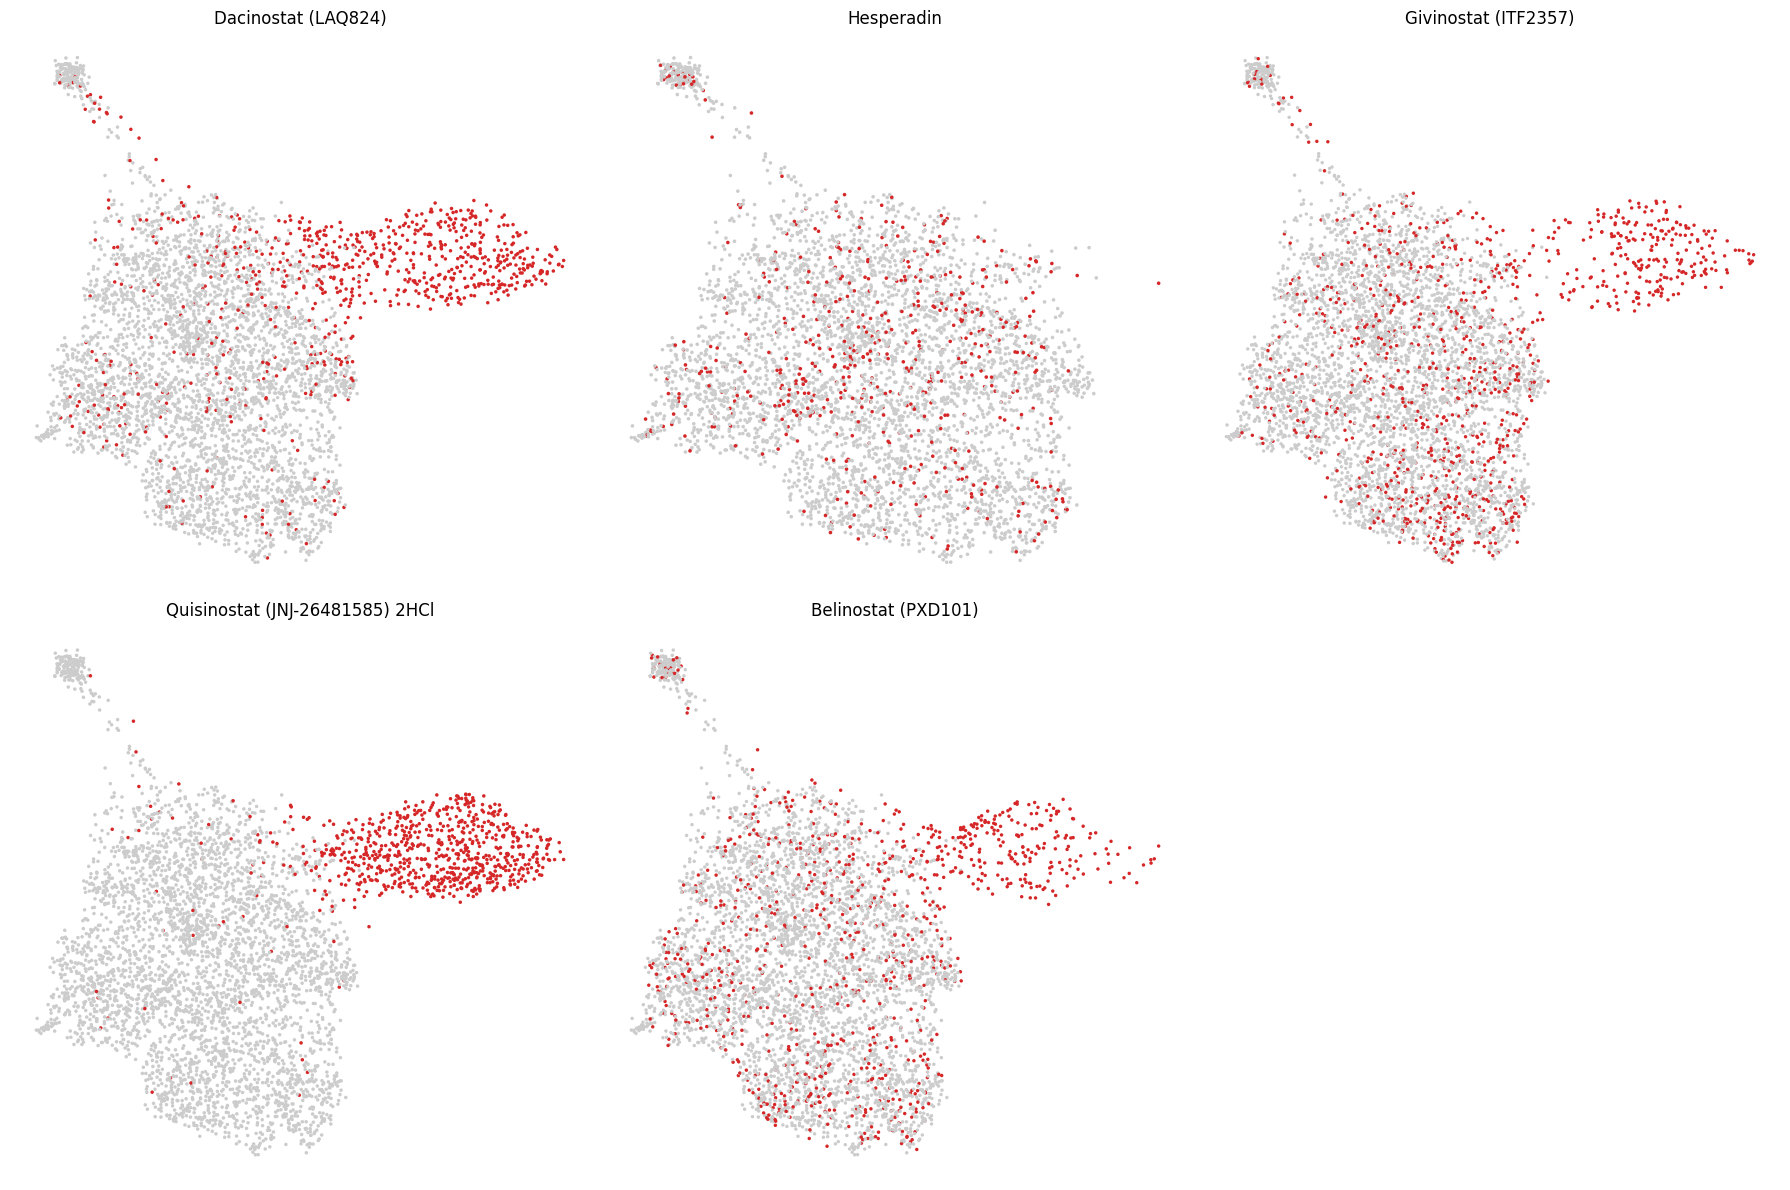

In [16]:
plot_drug_facets(adata)

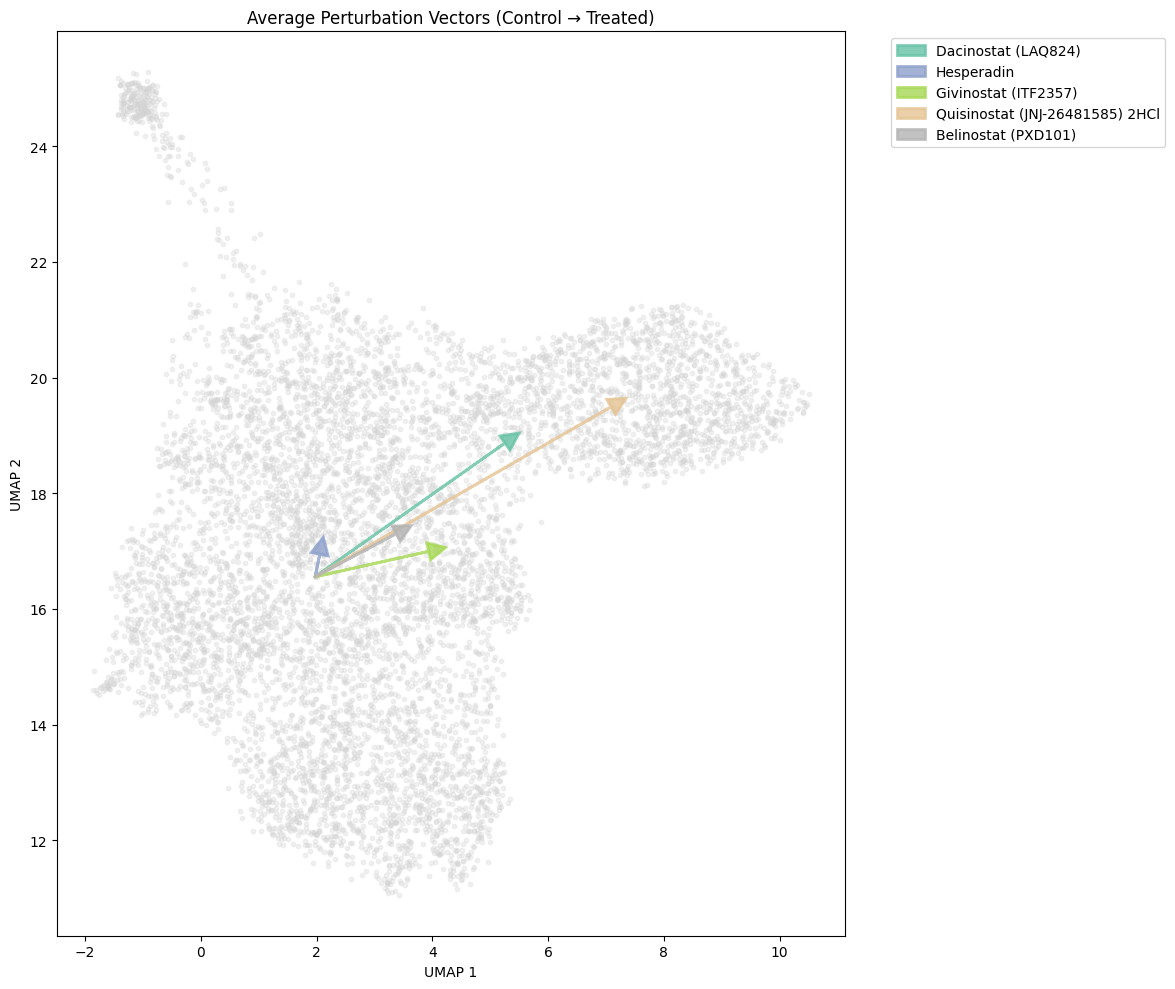

In [17]:
plot_displacement_vectors(adata)